C:\Users\KIIT\AppData\Local\Temp\ipykernel_33572\3286241007.py:11: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  df['rating'].fillna('Unknown', inplace=True)
C:\Users\KIIT\AppData\Local\Temp\ipykernel_33572\3286241007.py:12: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example

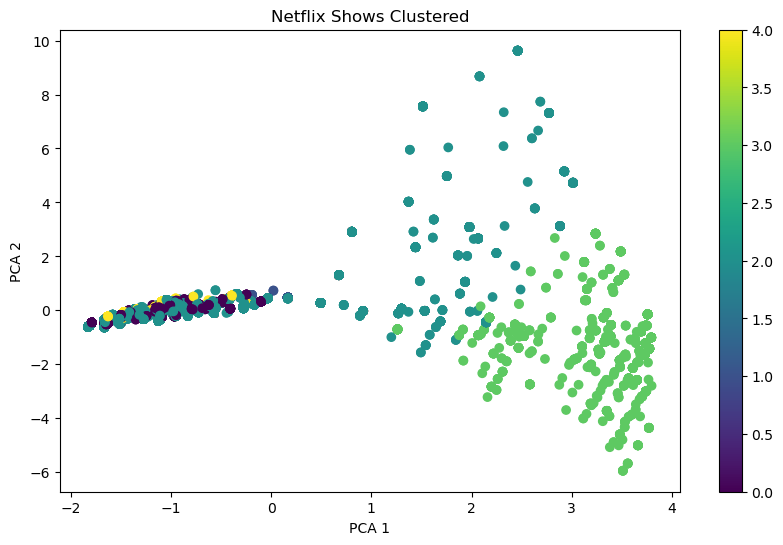

In [7]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

df = pd.read_csv("netflix_titles.csv")

df.drop(['show_id', 'description', 'cast'], axis=1, inplace=True)
df.isnull().sum()  
df.dropna(subset=['type', 'title', 'country', 'date_added', 'release_year'], inplace=True)  # Drop rows with missing key info
df['rating'].fillna('Unknown', inplace=True)
df['duration'].fillna('Unknown', inplace=True)

df = pd.get_dummies(df, columns=['type', 'rating'], drop_first=True)

# Split genre column and explode
df['genre_list'] = df['listed_in'].str.split(', ')
from sklearn.preprocessing import MultiLabelBinarizer

mlb = MultiLabelBinarizer()
genre_encoded = pd.DataFrame(mlb.fit_transform(df['genre_list']), columns=mlb.classes_, index=df.index)

df = pd.concat([df, genre_encoded], axis=1)
df.drop(['listed_in', 'genre_list'], axis=1, inplace=True)

features = df[ list(genre_encoded.columns)]

from sklearn.preprocessing import StandardScaler

scaler = StandardScaler()
X_scaled = scaler.fit_transform(features)

from sklearn.cluster import KMeans

kmeans = KMeans(n_clusters=5, random_state=42)
df['cluster'] = kmeans.fit_predict(X_scaled)

from sklearn.decomposition import PCA

pca = PCA(n_components=2)
X_pca = pca.fit_transform(X_scaled)

plt.figure(figsize=(10,6))
plt.scatter(X_pca[:,0], X_pca[:,1], c=df['cluster'], cmap='viridis')
plt.title('Netflix Shows Clustered')
plt.xlabel('PCA 1')
plt.ylabel('PCA 2')
plt.colorbar()
plt.show()


In [15]:
# 📌 STEP 1: Prepare features for content similarity
import pandas as pd
from sklearn.metrics.pairwise import cosine_similarity

# Copy original DataFrame
content_df = df.copy()

# Drop non-numeric and irrelevant columns (e.g., title, date, cluster)
non_numeric = content_df.select_dtypes(include=['object', 'datetime']).columns
content_features = content_df.drop(columns=non_numeric.union(['title', 'cluster']), errors='ignore')

# Fill any missing values
content_features = content_features.fillna(0)

# 🧠 STEP 2: Compute cosine similarity matrix
similarity_matrix = cosine_similarity(content_features)

# Map show titles to indices
indices = pd.Series(content_df.index, index=content_df['title']).drop_duplicates()

# 🎯 STEP 3: Define the recommendation function
def get_recommendations(title, similarity_matrix=similarity_matrix, df=content_df, indices=indices, top_n=5):
    if title not in indices:
        return f"❌ Title '{title}' not found in dataset."
    
    idx = indices[title]
    sim_scores = list(enumerate(similarity_matrix[idx]))
    sim_scores = sorted(sim_scores, key=lambda x: x[1], reverse=True)[1:top_n+1]
    show_indices = [i[0] for i in sim_scores]
    return df['title'].iloc[show_indices]

# ✅ STEP 4: Test the recommender
get_recommendations("Breaking Bad")


6662                    Easy A
6185                    Arthur
7149         Jumping the Broom
8365    The Invention of Lying
1111                Wild Child
Name: title, dtype: object